In [1]:
!pip install progress

You should consider upgrading via the '/Library/Frameworks/Python.framework/Versions/3.6/bin/python3.6 -m pip install --upgrade pip' command.


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import math
from Engine import Engine
from tqdm import tqdm
from progress.bar import IncrementalBar

In [3]:
def plot(trace_file: str, comm_file: str):
    df = pd.read_csv(trace_file, index_col=0)

    time = pd.read_csv(comm_file, index_col=0)
    time = time.fillna('')

    processes = len(df.columns) // 3
    fig, ax = plt.subplots(figsize=(15,8))

    max_time = 0
    status = {}
    isLegendSet = False
    for j in range(processes):
        x = list(df['timestamp' + str(j)].fillna(-1))[1:]
        y = list(df['state' + str(j)].fillna(-1))[1:]
        res = []
        for i, el in enumerate(x):
            if el == -1:
                continue
            el = list(map(float, el.split('-')))
            if el[1] > max_time:
                max_time = el[1]
            if y[i] == 'Await for receive':
                el.append('red')
            elif y[i] == 'Balance':
                el.append('blue')
            elif y[i] == 'Receive':
                el.append('brown')
            elif y[i] == 'Send':
                el.append('orange')
            elif y[i] == 'Solve':
                el.append('green')
            else:
                el.append('black')
            status[el[-1]] = False
            el.append(y[i])
            res.append(el)
        for el in res:
            if not status[el[2]] and not isLegendSet:
                status[el[2]] = True
                ax.plot(el[:-2], [j, j], color=el[2], linewidth=4.0, label=el[3])
            else:
                ax.plot(el[:-2], [j, j], color=el[2], linewidth=4.0)   
        isLegendSet = True
    scale = processes / max_time
    head_width = 2
    length = head_width * scale
    ax.legend()
    for col in time.columns:
        sndr, rcvr = map(int, col[1:-1].split(', '))
        for interval in time[col]:
            if interval != '':
                start, end = map(float, interval.split(':'))
                y = abs(rcvr-sndr)
                x = end-start
                gip = math.sqrt(y ** 2 + x ** 2)
                sin = y / gip
                width = (0.5 / 2 - 0.025 / 2) * sin + 0.025 / 2
                cos = x / gip
                lenth = (0.5 - 0.025) * cos + 0.025

                ax.arrow(start, sndr, end-start, rcvr-sndr, length_includes_head=True, width=width, head_length=lenth)
    plt.show()

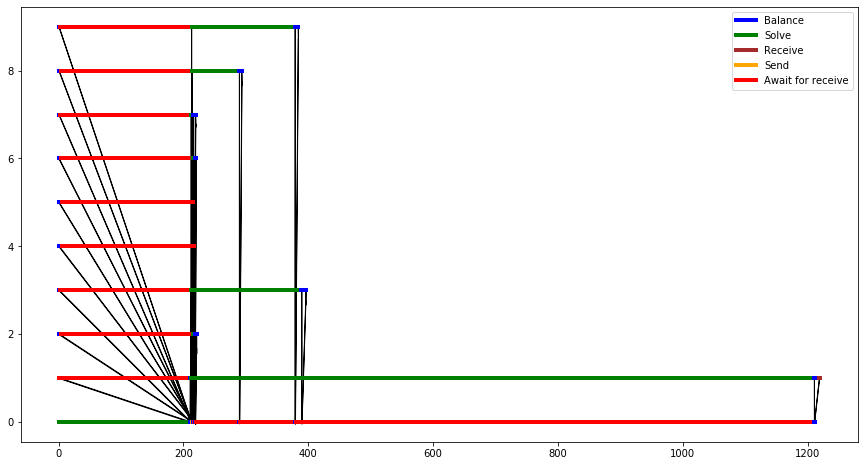

In [4]:
plot('Trace.csv', 'Communication.csv')

In [5]:
def count(trace_file: str, comm_file: str):
    df = pd.read_csv(trace_file, index_col=0)

    time = pd.read_csv(comm_file, index_col=0)
    time = time.fillna('')

    processes = len(df.columns) // 3

    max_time = 0
    Tseq = 0
    for j in range(processes):
        x = list(df['timestamp' + str(j)].fillna(-1))[1:]
        y = list(df['state' + str(j)].fillna(-1))[1:]
        res = []
        for i, el in enumerate(x):
            if el == -1:
                continue
            el = list(map(float, el.split('-')))
            if el[1] > max_time:
                max_time = el[1]
            if y[i] == 'Solve':
                Tseq += el[1] - el[0]
            el.append(y[i])
            res.append(el)

    acceleration = Tseq / max_time
    efficiency = acceleration / processes
    return acceleration, efficiency

In [6]:
# for i in range(10):
# count('Trace.csv', 'Communication.csv')+count('Trace.csv', 'Communication.csv')
count('Trace.csv', 'Communication.csv')

(1.3411533098187187, 0.13411533098187187)

In [7]:
eng = Engine(proc_amount=5, max_depth=10)

In [9]:
am = 1000
suma = (0, 0)
for i in tqdm(range(am)):
    try:
        eng = Engine(proc_amount=10, max_depth=18)
        eng.run()
    except Exception:
#         print('n')
        continue
    cur = count('Trace.csv', 'Communication.csv')
    suma = tuple(map(sum, zip(suma, cur)))
# suma
acc_average = suma[0] / am
eff_average = suma[1] / am

print(acc_average, eff_average)

100%|██████████| 1000/1000 [00:34<00:00, 29.30it/s]

1.5478159156620541 0.1547815915662055


In [ ]:
# time = pd.read_csv("Communication.csv", index_col=0)
# time = time.fillna('')
# time.head()


In [10]:
df.head()

,timestamp0,state0,args0,timestamp1,state1,args1,timestamp2,state2,args2
0,0,init,-,0,init,-,0,init,-
1,0.0-1.0,Balance,state=starting,0.0-1.0,Balance,state=starting,0.0-1.0,Balance,state=starting
2,1.0-19.0,Solve,tasks_am=6,1.0-2.0,Balance,state=nothing_to_receive,1.0-2.0,Balance,state=nothing_to_receive
3,19.0-20.0,Balance,state=solved,2.0-2.1,Send,dest=0,2.0-2.1,Send,dest=0
4,20.0-20.1,Receive,get_request,2.1-3.1,Balance,state=sent_get_request,2.1-3.1,Balance,state=sent_get_request
